In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from fredapi import Fred
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

In [ ]:
fred_api_key = "use_your_api_key"  # use your generated api key
fred = Fred(api_key=fred_api_key)

In [3]:
series_ids = {
    "inflation": "CPIAUCSL",       # Consumer Price Index (All Urban Consumers)
    "gdp": "GDP",                   # Gross Domestic Product
    "unemployment": "UNRATE",       # Unemployment Rate
    "policy_rate": "FEDFUNDS",      # Federal Funds Rate
    "industrial_production": "INDPRO"  # Industrial Production Index
}

# Define start date (5 years back from today)
start_date = (datetime.today() - timedelta(days=5*365)).strftime("%Y-%m-%d")
end_date = datetime.today().strftime("%Y-%m-%d")

# Fetch last 5 years of data
macro_data = pd.DataFrame()
for name, series_id in series_ids.items():
    macro_data[name] = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)

macro_data.index.name = "date"
macro_data.reset_index(inplace=True)

In [ ]:
"""GDP grows multiplicatively over time (compounding growth), not additively.
By interpolating in log space (log-linear interpolation), we ensure that
the implied monthly growth rates remain smooth and realistic, instead of
holding the value flat (forward fill) or introducing unnatural jumps.
This preserves the economic meaning of GDP changes while filling missing months."""
gdp_log = np.log(macro_data['gdp'])
macro_data['gdp'] = np.exp(gdp_log.interpolate(method='linear'))
macro_data = macro_data.dropna(subset=["gdp"]) # remove the start two months which remain null

In [5]:
# For CPI, GDP, and Industrial Production:
#   - These are index-level series (not in % terms).
#   - We convert them to % change to measure growth rates (inflation rate, GDP growth, production growth).

macro_data["inflation_pct_change"] = macro_data["inflation"].pct_change() * 100
macro_data["gdp_pct_change"] = macro_data["gdp"].pct_change() * 100
macro_data["industrial_production_pct_change"] = macro_data["industrial_production"].pct_change() * 100
macro_data = macro_data.dropna(subset=["industrial_production_pct_change"])

# For Unemployment Rate and Policy Rate:
#   - These are already expressed in % terms (e.g., 6.5 means 6.5% unemployment).
#   - The LEVEL itself is meaningful for yields (e.g., high unemployment → lower yields).
#   - Taking % change would distort interpretation (0.1 → 0.2 policy rate = 100% change but just 0.1pp move).
#   - Taking raw Δ change could help capture short-term shocks, but using levels retains long-term context.
#   - In many yield curve models, we keep the levels, or include both level & Δ if needed.

# policy_rate: The central bank's short-term interest rate (Federal Funds Rate), which guides borrowing costs and influences bond yields.

In [ ]:
# Fetch yields
yields = pd.DataFrame({
    "2y": fred.get_series("DGS2"),
    "5y": fred.get_series("DGS5"),
    "10y": fred.get_series("DGS10")
})
yields.index = pd.to_datetime(yields.index)

# date range
start = pd.Timestamp(start_date)
end = pd.Timestamp(end_date)
yields = yields.loc[start:end]

# Resample to monthly averages,
monthly_yields = yields.resample("MS").mean()


In [7]:
# 4. MERGE MACRO + YIELD DATA
data = macro_data.set_index("date").join(monthly_yields)

In [ ]:
data.isnull().sum() # no null data points
# The dataset has been cleaned and is now suitable for modeling.

inflation                           0
gdp                                 0
unemployment                        0
policy_rate                         0
industrial_production               0
inflation_pct_change                0
gdp_pct_change                      0
industrial_production_pct_change    0
2y                                  0
5y                                  0
10y                                 0
dtype: int64

In [ ]:
features = [
    "inflation_pct_change",
    "gdp_pct_change",
    "unemployment",
    "policy_rate",
    "industrial_production_pct_change"
]

X = data[features]
yields = ["2y", "5y","10y"]

--- 2y Yield Regression Summary (Train Set) ---
                            OLS Regression Results                            
Dep. Variable:                     2y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     122.8
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           2.47e-20
Time:                        23:37:33   Log-Likelihood:                -22.997
No. Observations:                  39   AIC:                             57.99
Df Residuals:                      33   BIC:                             67.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

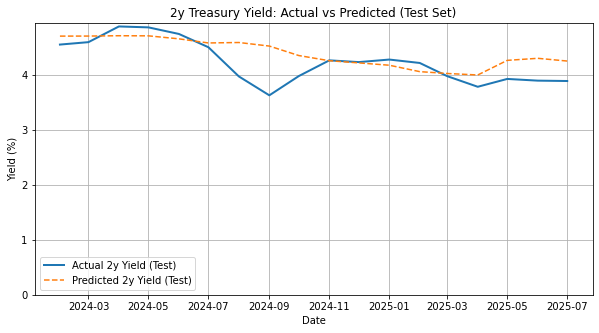

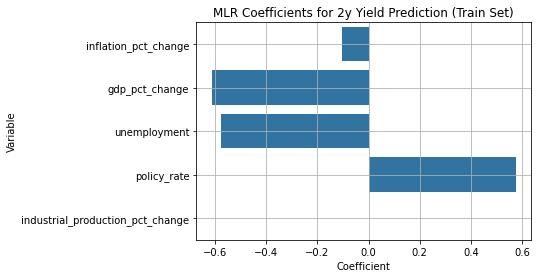

--- 5y Yield Regression Summary (Train Set) ---
                            OLS Regression Results                            
Dep. Variable:                     5y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     97.31
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           9.06e-19
Time:                        23:37:33   Log-Likelihood:                -16.972
No. Observations:                  39   AIC:                             45.94
Df Residuals:                      33   BIC:                             55.93
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

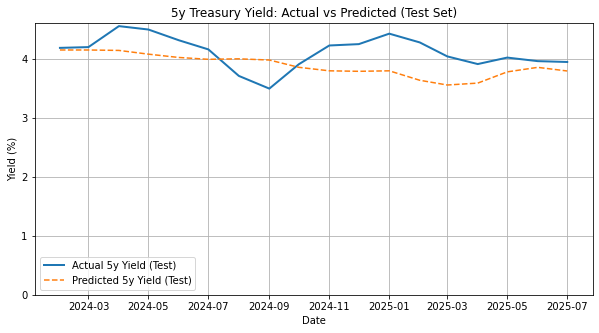

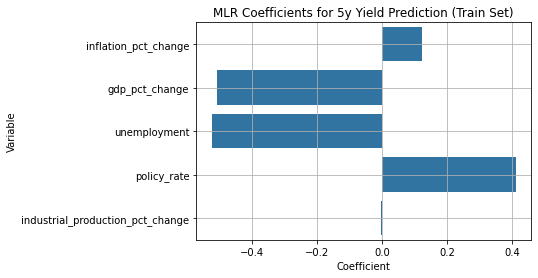

--- 10y Yield Regression Summary (Train Set) ---
                            OLS Regression Results                            
Dep. Variable:                    10y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     76.69
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           3.40e-17
Time:                        23:37:34   Log-Likelihood:                -12.699
No. Observations:                  39   AIC:                             37.40
Df Residuals:                      33   BIC:                             47.38
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

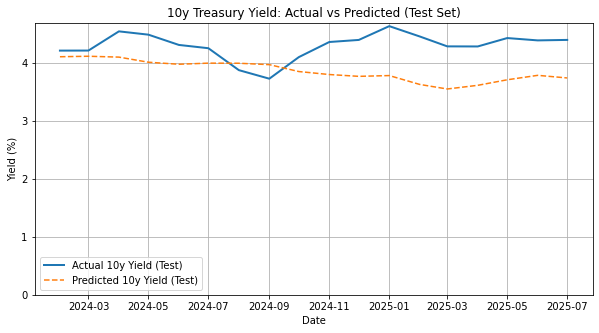

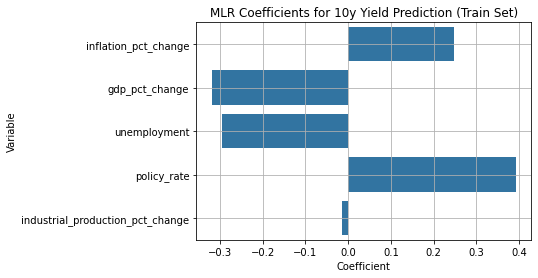

In [ ]:
for y_col in yields:
    y = data[y_col]

    # Split data into 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False  # shuffle=False keeps time order
    )

    # Statsmodels for regression summary on training set
    X_const_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_const_train).fit()
    print(f"--- {y_col} Yield Regression Summary (Train Set) ---")
    print(model.summary())

    # Sklearn for prediction
    mlr = LinearRegression()
    mlr.fit(X_train, y_train)
    y_pred_train = mlr.predict(X_train)
    y_pred_test = mlr.predict(X_test)

    # Evaluation
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)

    print(f"{y_col} Yield - Train RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")
    print(f"{y_col} Yield - Test RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}\n")

    # Plot Actual vs Predicted on test set
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test, label=f"Actual {y_col} Yield (Test)", linewidth=2)
    plt.plot(y_test.index, y_pred_test, label=f"Predicted {y_col} Yield (Test)", linestyle="--")
    plt.title(f"{y_col} Treasury Yield: Actual vs Predicted (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Yield (%)")
    plt.ylim(0)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Coefficients Plot (trained on training set)
    coef_df = pd.DataFrame({
        "Variable": features,
        "Coefficient": mlr.coef_
    })
    sns.barplot(x="Coefficient", y="Variable", data=coef_df)
    plt.title(f"MLR Coefficients for {y_col} Yield Prediction (Train Set)")
    plt.grid(True)
    plt.show()

#### 

In [ ]:
"""
2-Year Treasury Yield Regression

Model Fit:
R-squared: 0.949 → The model explains ~94.9% of the variation in 2y yields on the training set.
Adj. R-squared: 0.941 → Adjusted for number of predictors; still very high.
RMSE (Train/Test): 0.436 / 0.326 → Model predicts 2y yield reasonably well.
MAE (Train/Test): 0.350 / 0.238 → Average error is smaller on test set, indicating good generalization.

Significant Predictors (p < 0.05):
Unemployment: coef = -0.578 → Higher unemployment is associated with lower 2y yields.
Policy Rate: coef = 0.576 → Higher central bank policy rate increases the 2y yield.

Not Significant (p > 0.05):
Inflation, GDP change, Industrial Production change → These variables do not significantly impact the 2y yield in this dataset.

Other Notes:
Durbin-Watson: 0.418 → Strong positive autocorrelation in residuals. Might indicate that time-series nature of yields isn’t fully captured by this static OLS.

5-Year Treasury Yield Regression

Model Fit:
R-squared: 0.936 → ~93.6% of 5y yield variation explained.
Adj. R-squared: 0.927 → Adjusted for number of predictors; still very high.
RMSE (Train/Test): 0.374 / 0.367 → Similar performance on test data.
MAE (Train/Test): 0.291 / 0.315 → Slightly higher test MAE than train, but still acceptable.

Significant Predictors (p < 0.05):
Unemployment: coef = -0.524 → Same negative relationship.
Policy Rate: coef = 0.411 → Positive impact on 5y yields.

Not Significant:
Inflation, GDP change, Industrial Production → Again, not statistically significant.

10-Year Treasury Yield Regression

Model Fit:
R-squared: 0.921, Adj. R-squared: 0.909 → ~92% of variation explained.
RMSE (Train/Test): 0.335 / 0.536 → Larger performance drop on test set compared to shorter maturities.
MAE (Train/Test): 0.276 / 0.476 → Test error notably higher, suggesting reduced generalization.
Significant Predictors (p < 0.05):

Unemployment: coef = -0.295 → Higher unemployment lowers 10y yields, but effect is smaller than in 2y/5y models.
Policy Rate: coef = 0.392 → Positive relationship, but sensitivity is weaker than 2y and similar to 5y.
Not Significant: Inflation, GDP change, Industrial Production change.

Other Notes:
Durbin-Watson: 0.625 → Positive autocorrelation in residuals persists.
The long end (10y) appears less reactive to short-term macro changes, likely reflecting expectations about long-run economic and inflation trends rather than immediate policy moves.

Key Takeaways Across 2y, 5y, 10y Models:

1) Policy rate and unemployment are the dominant, statistically significant drivers for yields across all maturities in this dataset.
2) Shorter maturities (2y) show stronger sensitivity to policy rate changes, while longer maturities (10y) are less reactive.
3) Inflation, GDP growth, and industrial production were not significant for any maturity in this sample period, potentially due to stable macro conditions or policy dominance.
4) Autocorrelation in residuals for all maturities indicates that static OLS misses time-dependent dynamics — time-series or dynamic regression models could improve performance.

Generalization:
2y and 5y models maintain stable train–test performance, while 10y shows notable performance degradation on test data,
suggesting more noise or unmodeled factors affecting long-term rates."""

'\n2-Year Treasury Yield Regression\n\nModel Fit:\nR-squared: 0.949 → The model explains ~94.9% of the variation in 2y yields on the training set.\nAdj. R-squared: 0.941 → Adjusted for number of predictors; still very high.\nRMSE (Train/Test): 0.436 / 0.326 → Model predicts 2y yield reasonably well.\nMAE (Train/Test): 0.350 / 0.238 → Average error is smaller on test set, indicating good generalization.\n\nSignificant Predictors (p < 0.05):\nUnemployment: coef = -0.578 → Higher unemployment is associated with lower 2y yields.\nPolicy Rate: coef = 0.576 → Higher central bank policy rate increases the 2y yield.\n\nNot Significant (p > 0.05):\nInflation, GDP change, Industrial Production change → These variables do not significantly impact the 2y yield in this dataset.\n\nOther Notes:\nDurbin-Watson: 0.418 → Strong positive autocorrelation in residuals. Might indicate that time-series nature of yields isn’t fully captured by this static OLS.\n\n5-Year Treasury Yield Regression\n\nModel Fit